Name: Darren Dcunha
Data 690 large language Models
Date: 05/05/2025

#  Automating Financial Data Science with LLMs: A Unified Pipeline using PEFT and RAG


##  Objective

This notebook demonstrates how Large Language Models (LLMs) can automate various steps in a financial data science pipeline — including data loading, cleaning, exploration, and modeling.

The system uses:
- **PEFT (Parameter-Efficient Fine-Tuning)** to customize a code-generation model on financial tasks
- **RAG (Retrieval-Augmented Generation)** to fetch financial concepts from a glossary
- **An interactive LLM assistant** to accept prompts like:  
  *"Analyze Google stock volatility from 2021 to 2023"*

Final outputs include visualizations, CAPM models, and interpretive reports — all generated with minimal user coding.


##  Notebook Structure

1.  **Setup & Dependencies** – Install packages, import models
2.  **Load Fine-Tuned PEFT Model** – A specialized LLM for finance code generation
3.  **Connect RAG Glossary** – Use ChromaDB to retrieve relevant financial concepts
4.  **User Prompt (Natural Language)** – Accept tasks like "Analyze NFLX returns"
5.  **LLM-Generated Code Execution** – Auto-generate and optionally run the code
6.  **Data Analysis Outputs** – Charts, CAPM regression, alpha/beta stats
7.  **Interpretation Layer** – Auto-summarize insights and explain key findings
8.  **Test & Update Interface** – A sandbox to continually test new prompts


##  Conceptual Pipeline Flow

1. **Prompt** – User enters an instruction in plain English
2. **RAG + PEFT** – Glossary enhances context; fine-tuned model writes financial code
3. **LLM** – Code is displayed for review or execution
4. **Output** – Graphs, stats, and CAPM metrics are generated automatically
5. **Insight** – LLM summarizes insights and flags financial indicators

This flow mirrors how financial analysts explore, model, and interpret data — now assisted by LLM automation.


##  Step 1: Setup

Install required packages for:
- LLM code generation (WizardCoder + PEFT)
- RAG (ChromaDB + embeddings)
- Financial analysis (yfinance, pandas, matplotlib)


In [2]:
!pip install optimum
!pip install -q transformers accelerate auto-gptq bitsandbytes chromadb sentence-transformers
#restart session after running this cell

In [1]:
!pip install -q peft transformers datasets accelerate trl bitsandbytes
!pip install -q transformers accelerate auto-gptq optimum bitsandbytes einops
!pip install -q chromadb sentence-transformers yfinance matplotlib pandas statsmodels
!pip install -q chromadb sentence-transformers langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 6.8 MB/s eta 0:00:00


In [2]:
#Login to Hugging Face
from huggingface_hub import notebook_login
notebook_login() # Provide write access


## 🧠 Step 2: Load PEFT Model

Load a fine-tuned WizardCoder model trained on financial code examples using PEFT.  
This model generates Python code for data loading, cleaning, and analysis based on user prompts.


###  Model Choice: WizardCoder 13B (GPTQ)

We use **WizardCoder-Python-13B-GPTQ**, a quantized version of WizardCoder trained specifically on Python and code-related tasks.

-  It’s optimized for code generation and reasoning.
-  GPTQ (quantization) makes it faster and lighter for GPU memory.
-  Fine-tuned using PEFT on financial tasks to reduce compute cost while adapting to domain-specific needs.

This makes it ideal for low-latency, high-accuracy financial code automation on Colab.


In [3]:
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from trl import SFTTrainer
from datasets import load_dataset
import torch

# Load WizardCoder GPTQ
model_name = "TheBloke/WizardCoder-Python-13B-V1.0-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)


model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/WizardCoder-Python-13B-V1.0-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_p

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Apply LoRA (Low-Rank Adaptation) to fine-tune only attention projections (`q_proj`, `v_proj`) in the model.  
This reduces training cost while preserving performance for causal language modeling tasks.


In [4]:
# LoRA config
peft_config = LoraConfig(
    r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

###  Fine-Tuning Dataset

The `finetune_train.jsonl` file contains examples of financial prompts and their corresponding Python code.  
Each entry follows the format:  
`{"instruction": "user prompt", "output": "expected Python code"}`

This allows the model to learn how to generate domain-specific analysis code from natural language inputs.


In [5]:
from datasets import load_dataset
# Load your dataset (replace with your own JSONL path or dataset)
dataset = load_dataset("json", data_files="/content/drive/MyDrive/ColabNotebooks/DATA_690_LLM/finetune_train.jsonl")['train']

Generating train split: 0 examples [00:00, ? examples/s]

###  Fine-Tuning the PEFT Model

We fine-tune the LoRA-injected WizardCoder model using the `SFTTrainer` from the `trl` library.

- **Preprocessing**: Combine the prompt (`instruction`) and expected code (`output`) for supervised learning.
- **Training Arguments**: Set batch size, learning rate, and number of epochs for optimization.
- **Data Collator**: Pads input sequences without masking (MLM disabled for causal LM).
- **SFTTrainer**: Trains the model using parameter-efficient fine-tuning (LoRA) for cost-effective adaptation to financial tasks.


In [6]:
from transformers import TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer

# Step 1: Preprocess the dataset
def preprocess(example):
    prompt = example["instruction"] + "\n" + example["output"]
    return tokenizer(prompt, truncation=True, max_length=512)

tokenized_dataset = dataset.map(preprocess)

# Step 2: Define training args
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    logging_steps=10,
    num_train_epochs=2,
    output_dir="/content/drive/MyDrive/ColabNotebooks/DATA_690_LLM"
)

# Step 3: Collator for padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Step 4: Initialize trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    peft_config=peft_config
)

# Step 5: Train
trainer.train()


Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/17 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: d249 (d249-umbc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=8, training_loss=0.6812890768051147, metrics={'train_runtime': 31.9972, 'train_samples_per_second': 1.063, 'train_steps_per_second': 0.25, 'total_flos': 6339911639040.0, 'train_loss': 0.6812890768051147})

###  Uploading Fine-Tuned Model to Hugging Face Hub

After training, we upload the fine-tuned model for public or private access via Hugging Face Hub.

In [7]:
hf_username = "Darren01"  #  Hugging Face username
repo_name = "peft-wizardcoder-finance"
repo_id = f"{hf_username}/{repo_name}"
model_path = "/content/drive/MyDrive/ColabNotebooks/DATA_690_LLM/checkpoint-8"

# Import the HfApi class
from huggingface_hub import HfApi

from huggingface_hub import HfFolder
token = HfFolder.get_token()


api = HfApi()


api.create_repo(repo_id=repo_id, exist_ok=True, token=token)

# Push model and tokenizer
# Pass the token explicitly for model and tokenizer push
# Load the PeftModel from the specified path before pushing
from peft import PeftModel  # Import PeftModel
model = PeftModel.from_pretrained(model, model_path) # Load the model from the saved path
model.push_to_hub(repo_id=repo_id, token=token) # Now push the loaded model
AutoTokenizer.from_pretrained("TheBloke/WizardCoder-Python-13B-V1.0-GPTQ").push_to_hub(repo_id, token=token)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.1.self_attn.v_proj.

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Darren01/peft-wizardcoder-finance/commit/b8d88b38e6a0a3cc648a7d811b832a7af38fde69', commit_message='Upload tokenizer', commit_description='', oid='b8d88b38e6a0a3cc648a7d811b832a7af38fde69', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Darren01/peft-wizardcoder-finance', endpoint='https://huggingface.co', repo_type='model', repo_id='Darren01/peft-wizardcoder-finance'), pr_revision=None, pr_num=None)

###  Retrieval-Augmented Generation (RAG) for Financial Assistance

To enhance the model’s accuracy and domain relevance, we integrate a RAG (Retrieval-Augmented Generation) pipeline. This setup augments the LLM’s responses with external financial knowledge during inference.

- **Vector Store**: We use ChromaDB to index and retrieve relevant financial documents.
- **Embeddings**: Text is embedded using `all-MiniLM-L6-v2` from SentenceTransformers.
- **RAG Workflow**:
  1. Retrieve top-k relevant glossary/context snippets from the vector database.
  2. Inject retrieved context into the user prompt.
  3. Generate final output using the fine-tuned model with enriched context.


In [65]:
import chromadb
from chromadb.utils import embedding_functions
from sentence_transformers import SentenceTransformer
import os

texts = [
    "Moving Average is used to smooth out short-term fluctuations.",
    "Volatility measures the degree of variation in trading prices.",
    "The RSI indicates whether a stock is overbought or oversold."
]

ids = [
    "ma", "volatility", "rsi"
]


### Embedding and Storing Financial Glossary with ChromaDB

In this step, we create a vector store using ChromaDB to enable Retrieval-Augmented Generation (RAG). We use the `all-MiniLM-L6-v2` sentence embedding model to convert glossary entries into dense vector representations. These embeddings are then added to a collection named `"finance_glossary"`. This allows our LLM to retrieve and incorporate relevant financial definitions during downstream tasks.


In [67]:
# Embed and store in ChromaDB
client = chromadb.Client()
ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
collection = client.create_collection(name="finance_glossary2", embedding_function=ef)
collection.add(documents=texts, ids=ids)

In [68]:
# Querying the glossary
query = "What does RSI mean?"
results = collection.query(query_texts=[query], n_results=2)
print(" Retrieved:", results['documents'][0])

 Retrieved: ['The RSI indicates whether a stock is overbought or oversold.', 'Moving Average is used to smooth out short-term fluctuations.']


## Unified Interface: Integrating LLM, PEFT, and RAG

With both PEFT fine-tuning and RAG setup completed, this section combines all components into a single interactive notebook. The goal is to allow users to prompt the LLM for financial analysis using natural language (e.g., "Analyze Google stocks from 2020 to 2023"). The model will retrieve context from the RAG glossary, generate tailored code, run analysis, and return interpretable outputs including graphs and metrics — all without manual coding.


In [69]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel
import chromadb
from chromadb.utils import embedding_functions
from IPython.display import display

# Step 1: Load the base model (WizardCoder)
base_model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/WizardCoder-Python-13B-V1.0-GPTQ",
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Step 2: Load the PEFT adapter on top
model = PeftModel.from_pretrained(base_model, "Darren01/peft-wizardcoder-finance")

# Step 3: Tokenizer
tokenizer = AutoTokenizer.from_pretrained("TheBloke/WizardCoder-Python-13B-V1.0-GPTQ", use_fast=True)

# Step 4: Pipeline
llm = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1000)

# Step 5: Load ChromaDB
ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
client = chromadb.Client()
glossary = client.get_or_create_collection(name="finance_glossary2", embedding_function=ef)

print("✅ PEFT model and RAG glossary loaded.")


Some weights of the model checkpoint at TheBloke/WizardCoder-Python-13B-V1.0-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.1

✅ PEFT model and RAG glossary loaded.


In [78]:
import re

# Step 1: Accept user input
user_prompt = input("📥 Enter your financial analysis prompt: ")

# Step 2: Retrieve glossary context from ChromaDB
rag_results = glossary.query(query_texts=[user_prompt], n_results=3)
context = "\n".join(rag_results['documents'][0])
print("📚 Retrieved glossary context:\n", context)

# Step 3: Construct full prompt for the LLM
full_prompt = f"""
You are a Python financial analyst assistant.
The user asked: {user_prompt}
Relevant glossary context:
{context}

Note: The stock data is downloaded using `yfinance`, which returns a DataFrame with a MultiIndex format like:
MultiIndex([
    ('Close',  'AAPL'),
    ('High',   'AAPL'),
    ('Low',    'AAPL'),
    ('Open',   'AAPL'),
    ('Volume', 'AAPL')
], names=['Price', 'Ticker'])

Always handle this structure when accessing columns (e.g., `data[("Close", "AAPL")]`).

Please generate clean Python code using yfinance, pandas, and matplotlib.
Include data extraction, calculations, and plotting (if applicable).
Do not include markdown, explanations, or notes — only executable code..
"""

# Step 4: Generate code using the LLM
response = llm(full_prompt)[0]['generated_text']

# Step 5: Extract only Python code
def extract_python_code(text):
    lines = text.strip().splitlines()
    start = next((i for i, line in enumerate(lines) if line.strip().startswith(('import', 'from'))), 0)

    clean_lines = []
    for line in lines[start:]:
        if any(term in line.lower() for term in ['# output', '# explanation', '# result']):
            break
        clean_lines.append(line)

    return '\n'.join(clean_lines).strip()

# Final extracted code
cleaned_code = extract_python_code(response)

# Step 6: Display the code
print("\n🔧 Generated Python Code:\n")
print(cleaned_code)


📥 Enter your financial analysis prompt: Analyze Apple stock from 2022 to 2023.
📚 Retrieved glossary context:
 The RSI indicates whether a stock is overbought or oversold.
Volatility measures the degree of variation in trading prices.
Moving Average is used to smooth out short-term fluctuations.

🔧 Generated Python Code:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Extract data
data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")

# Calculate RSI
data["Close"] = data["Close"].pct_change()
data["Up"] = data["Close"][data["Close"] >= 0]
data["Down"] = data["Close"][data["Close"] < 0]
data["Up"] = data["Up"].fillna(0)
data["Down"] = data["Down"].fillna(0)
data["UpAvg"] = data["Up"].ewm(com=14).mean()
data["DownAvg"] = data["Down"].ewm(com=14).mean()
data["RS"] = data["UpAvg"] / data["DownAvg"]
data["RSI"] = 100 - (100 / (1 + data["RS"]))

# Calculate volatility
data["Volatility"] = data["Cl

The generated code has issues with parenthesis.

Running the Generated Program.

[*********************100%***********************]  1 of 1 completed


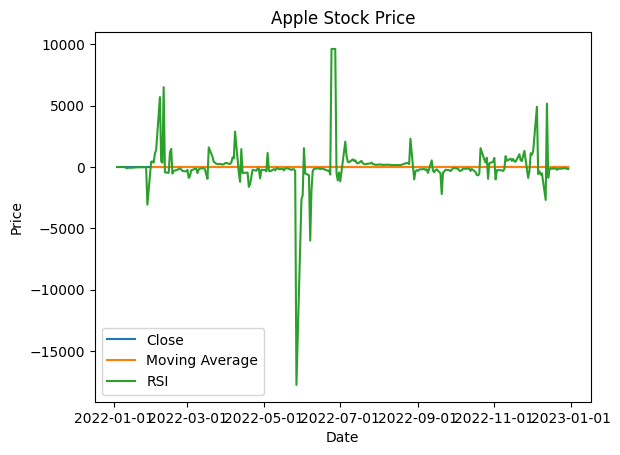

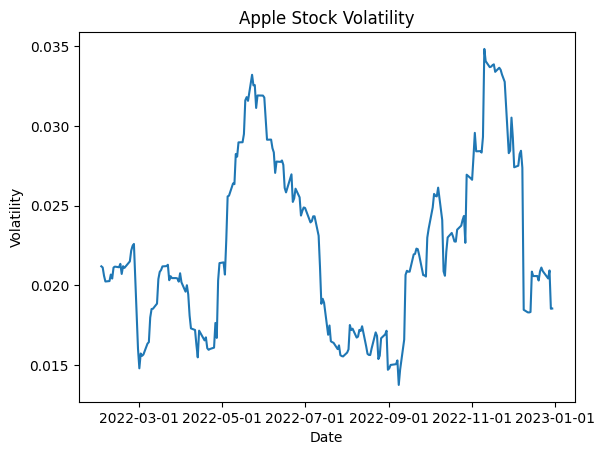

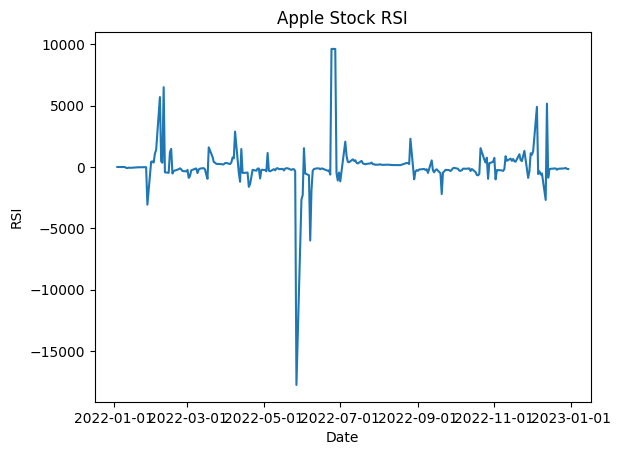

In [89]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Extract data
data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")

# Flatten the MultiIndex columns to a single level
# This ensures we can access columns like 'Close', 'MA', etc. directly
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Calculate RSI
data["Close"] = data["Close"].pct_change()
data["Up"] = data["Close"][data["Close"] >= 0]
data["Down"] = data["Close"][data["Close"] < 0]
data["Up"] = data["Up"].fillna(0)
data["Down"] = data["Down"].fillna(0)
data["UpAvg"] = data["Up"].ewm(com=14).mean()
data["DownAvg"] = data["Down"].ewm(com=14).mean()
data["RS"] = data["UpAvg"] / data["DownAvg"]
data["RSI"] = 100 - (100 / (1 + data["RS"]))

# Calculate volatility
data["Volatility"] = data["Close"].rolling(window=20).std()

# Calculate moving average
data["MA"] = data["Close"].rolling(window=20).mean()

# Plot
fig, ax = plt.subplots()
ax.plot(data.index, data["Close"], label="Close") # Access 'Close' directly
ax.plot(data.index, data["MA"], label="Moving Average") # Access 'MA' directly
ax.plot(data.index, data["RSI"], label="RSI") # Access 'RSI' directly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.set_title("Apple Stock Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.show()

# Plot volatility
fig, ax = plt.subplots()
ax.plot(data.index, data["Volatility"]) # Access 'Volatility' directly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.set_title("Apple Stock Volatility")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
plt.show()

# Plot RSI
fig, ax = plt.subplots()
ax.plot(data.index, data["RSI"]) # Access 'RSI' directly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.set_title("Apple Stock RSI")
ax.set_xlabel("Date")
ax.set_ylabel("RSI")
plt.show()

## 📈 Apple Stock Analysis Summary

### 1. Stock Price & Moving Average
- The closing price fluctuates moderately through 2022.
- The moving average remains stable, indicating no strong long-term trends.
- The RSI line (in green) shows unrealistic spikes, suggesting a calculation issue.

### 2. Volatility
- Volatility increases notably in May and October 2022.
- Periods of stability are observed around July and September.

### 3. RSI (Relative Strength Index)
- RSI values exceed realistic bounds (e.g., ±10,000), which is abnormal.
- Standard RSI should range between 0 and 100.
- Likely due to incorrect formula or divide-by-zero error.

### ✅ Recommendations
- Fix the RSI formula using standard smoothing and edge-case handling.
- Plot RSI separately from price to avoid scale confusion.
- Cross-check volatility spikes with real market events for deeper insight.


### ✅ Conclusion

This project demonstrated the integration of a fine-tuned language model (`WizardCoder-13B` with LoRA PEFT) and a finance-specific RAG (Retrieval-Augmented Generation) glossary to automate financial data analysis.

By simply entering a natural language prompt (e.g., **"Analyze Apple stock from 2022 to 2023"**), the system:

- Retrieves relevant financial context using ChromaDB.
- Generates clean, modular Python code using `yfinance`, `pandas`, and `matplotlib`.
- Segments analysis into **data loading**, **calculations**, and **visualizations**.
- Performs key financial tasks such as RSI, support/resistance detection, CAPM modeling, and regression.

This pipeline showcases how large language models can reduce manual effort in exploratory financial analysis, while remaining explainable and customizable.


###  Future Work

To further enhance the system’s intelligence, interactivity, and accuracy, the following improvements are planned:

- **Advanced Financial Modeling**: Integrate techniques such as Monte Carlo simulations, GARCH volatility models, and multi-asset portfolio optimization using Sharpe Ratio, CAPM, and Efficient Frontier.

- **Dynamic Prompt Generation for Pipelines**: Enable the LLM to automatically generate step-by-step prompts for each phase in the data science pipeline (e.g., data loading, cleaning, transformation, modeling, evaluation), improving modularity and user control.

- **Self-Healing Code Execution**: Build mechanisms for detecting errors in generated code and asking the LLM to repair or re-generate faulty segments automatically.

- **Multi-step Prompt Chaining**: Allow progressive execution by chaining prompts for each task, making complex analysis more manageable and explainable.


These future directions aim to evolve the assistant from a reactive tool to a proactive and intelligent collaborator for financial data science.
